# Ship Detection in the Port of Los Angeles (POLA)

In this notebook the labelled dataset
https://www.kaggle.com/rhammell/ships-in-satellite-imagery
is used to train a model to detect the presence of ships in the Port of Los Angeles.

I have also used 
https://towardsdatascience.com/train-image-recognition-ai-with-5-lines-of-code-8ed0bdd8d9ba
as a guide for the training of the machine learning model

In [1]:
# Let's see if it will import:
with open('POLA_vis_images.txt', 'r') as file:  
    POLA_tifs = [tif.rstrip() for tif in file.readlines()]

In [2]:
import json, sys, random
from pathlib import Path
from wand.image import Image
import numpy as np
from imageai.Prediction.Custom import ModelTraining
import rasterio
import matplotlib.pyplot as plt

In [3]:
# The code below has been run in a Google Colab session in order to quickly train the model
#model_trainer = ModelTraining()
#model_trainer.setModelTypeAsResNet()
#model_trainer.setDataDirectory("ships_sat")
#model_trainer.trainModel(num_objects=2, num_experiments=20, enhance_data=True, batch_size=32, show_network_summary=True)

Now we sca over the image in 80x80 squares to find the ones that contain ships. We begin by loading a trial image and work out how to go about the scanning process

In [4]:
# Path to the images folder
path = '..//..//..//Prep_Analysis//'

In [ ]:
# Open and read the .tif file
img1 = rasterio.open(path+'images//'+POLA_tifs[0]).read()

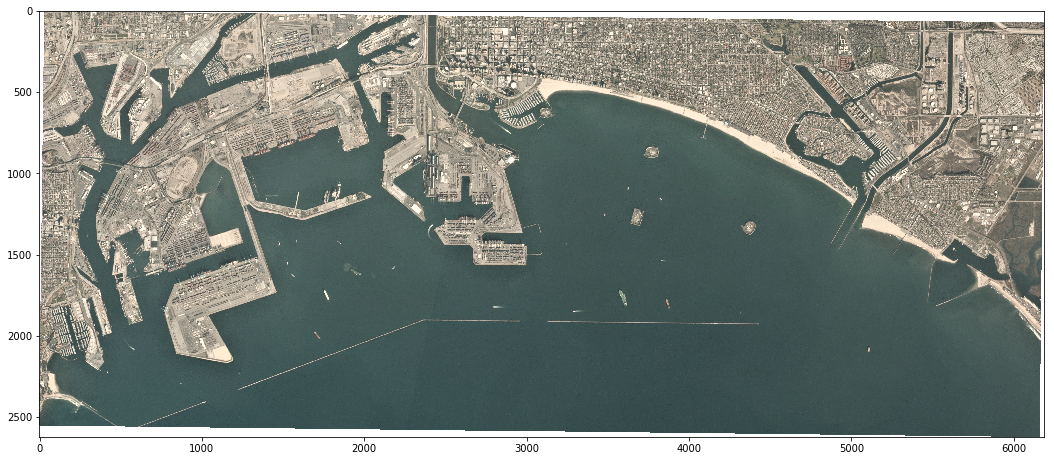

In [125]:
# Display the full image:
%matplotlib inline
plt.figure(figsize = (18,36))
plt.imshow(np.dstack(img1))
plt.show()

<IPython.core.display.Javascript object>


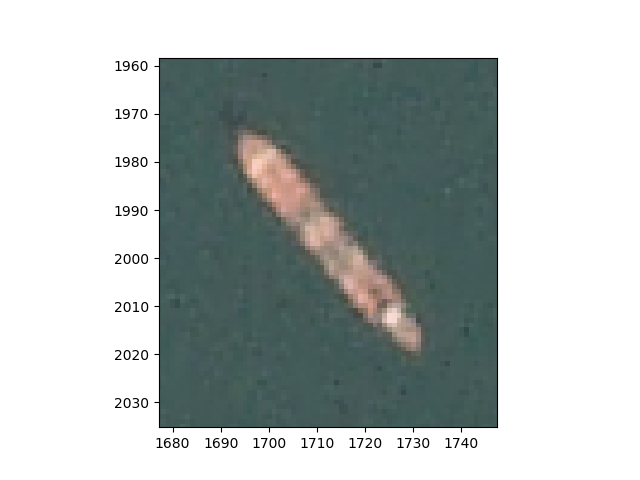

In [124]:
%matplotlib notebook

# Show a close up on a ship
plt.imshow(np.dstack(img1))
plt.show()

In [6]:
# Make a folder to hold full png conversions of the .tif files
if Path(path+'images//full_png_imgs//').exists() == False:
    Path.mkdir(path+'images//full_png_imgs')

In [7]:
# Convert .tif to .png:
if Path('images//full_png_imgs//'+POLA_tifs[0][0:-4]+'.png').exists() == False:
    with Image(filename=path+'images//'+POLA_tifs[0]) as org_img:
        with org_img.convert('png') as conv_img:
            conv_img.sample(int(org_img.size[0]),int(org_img.size[1]))
            conv_img.save(filename=path+'images//full_png_imgs//'+POLA_tifs[0][0:-4]+'.png')

C:\Users\Ronald Maj\AppData\Local\conda\conda\envs\TDI-Challenge\lib\site-packages\wand\image.py:4623: CoderWarning: Unknown field with tag 34737 (0x87b1) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/999
  self.raise_exception()


In [8]:
png1 = rasterio.open(path+'images//full_png_imgs//'+POLA_tifs[0][0:-4]+'.png').read()

C:\Users\Ronald Maj\AppData\Local\conda\conda\envs\TDI-Challenge\lib\site-packages\rasterio\__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


In [9]:
img1.shape

(4, 2623, 6186)

In [10]:
png1.shape

(4, 2623, 6186)

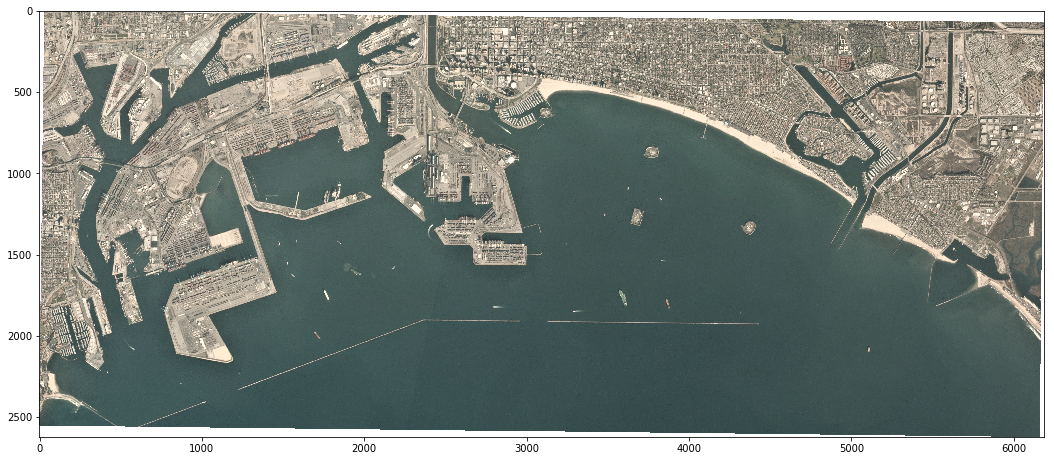

In [11]:
plt.figure(figsize = (18,36))
plt.imshow(np.dstack(png1))
plt.show()

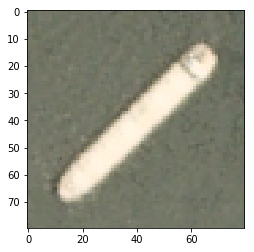

In [12]:
# Display what the images the model was trained on look like:
ship_path = 'ships-in-satellite-imagery//shipsnet//ships//'
ship1 = rasterio.open(path+ship_path+'1__20180712_180755_0f2d__-118.15166889302655_33.73582571921725'+'.png').read()

plt.figure()
plt.imshow(np.dstack(ship1))
plt.show()

In [55]:
import math
vert_sq = 2623/80
hori_sq = 6186/80
r_vert = math.floor(vert_sq)
r_hori = math.floor(hori_sq)
sq_tot = r_vert*r_hori
print(f'''We can have {vert_sq} 80x80 squares in the vertical direction and {hori_sq} squares 
in the horizontal direction, which rounds down to {r_vert} and {r_hori}, respectively.

This will give a total of {sq_tot} squares over each image.''')


We can have 32.7875 80x80 squares in the vertical direction and 77.325 squares 
in the horizontal direction, which rounds down to 32 and 77, respectively.

This will give a total of 2464 squares over each image.


Therefore, we will be able to divide each image into a grid of 32 by 77 80x80 squares (2464 total), with some missing space on the edges.

We will choose the top left corner as the first 80x80 square and then proceed from there.

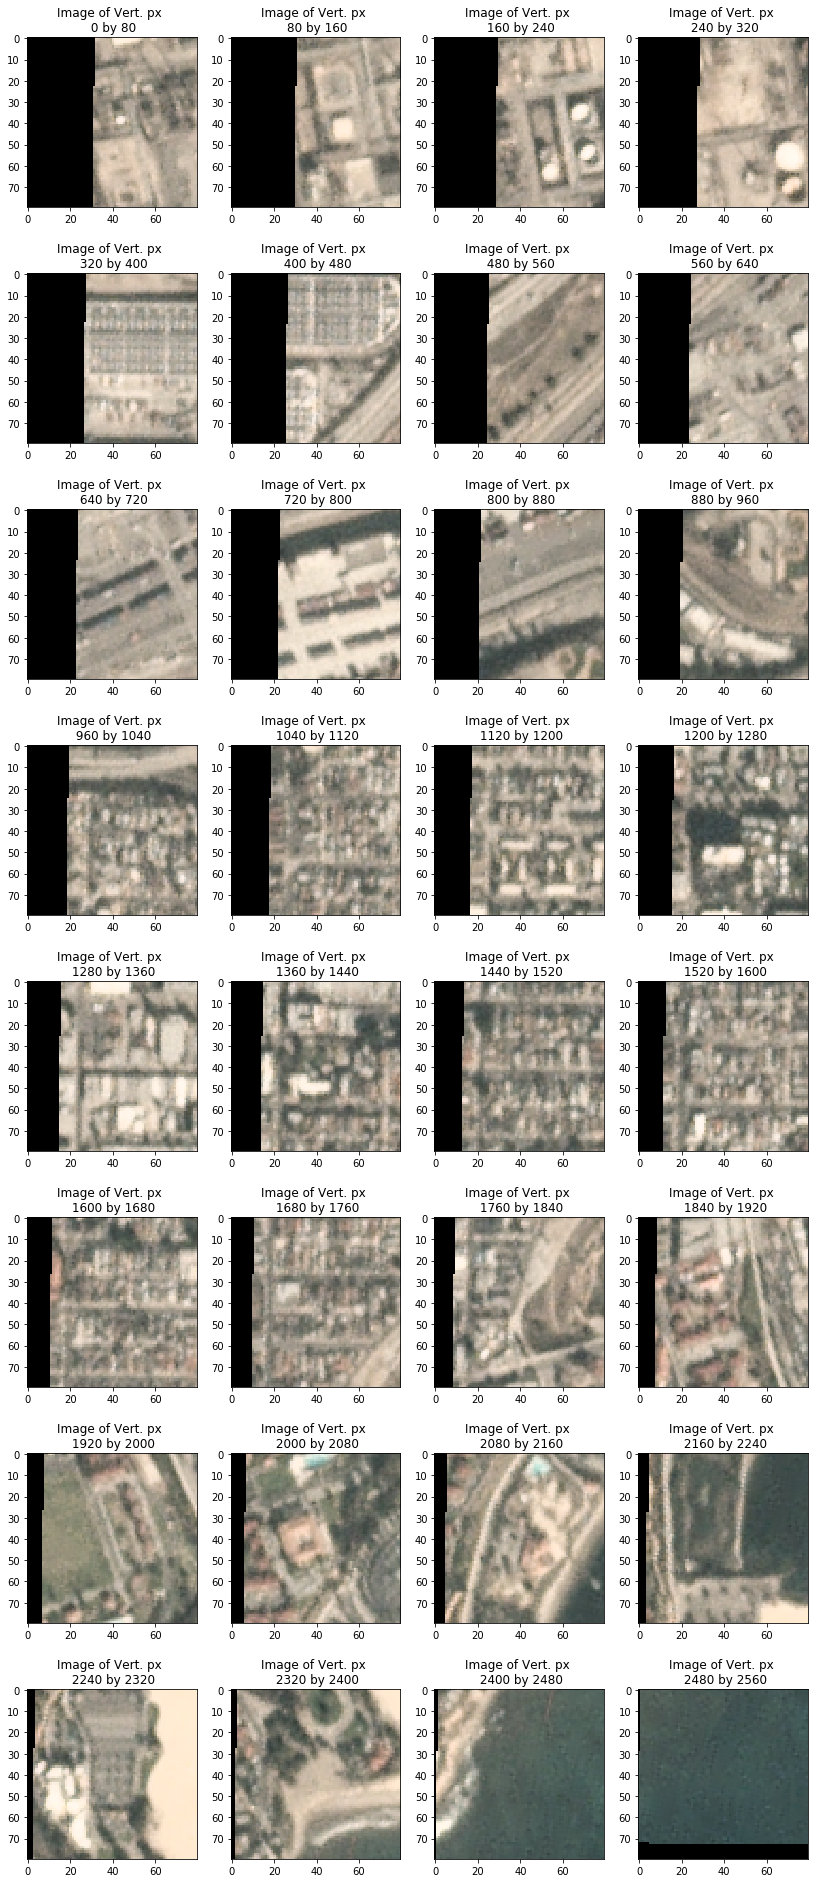

In [16]:
fig, axes = plt.subplots(8, 4)
fig.set_figheight(34)
fig.set_figwidth(14)
png1_3 = png1[0:3]
mn = 0
mx = mn+80
for i in range(8):
    for j in range(4):
        axes[i,j].imshow(np.dstack(png1_3[0:3,mn:mx,0:80]))
        axes[i,j].set_title('Image of Vert. px \n {} by {}'.format(mn,mx))
        mn += 80
        mx = mn+80

#plt.tight_layout()
plt.show()

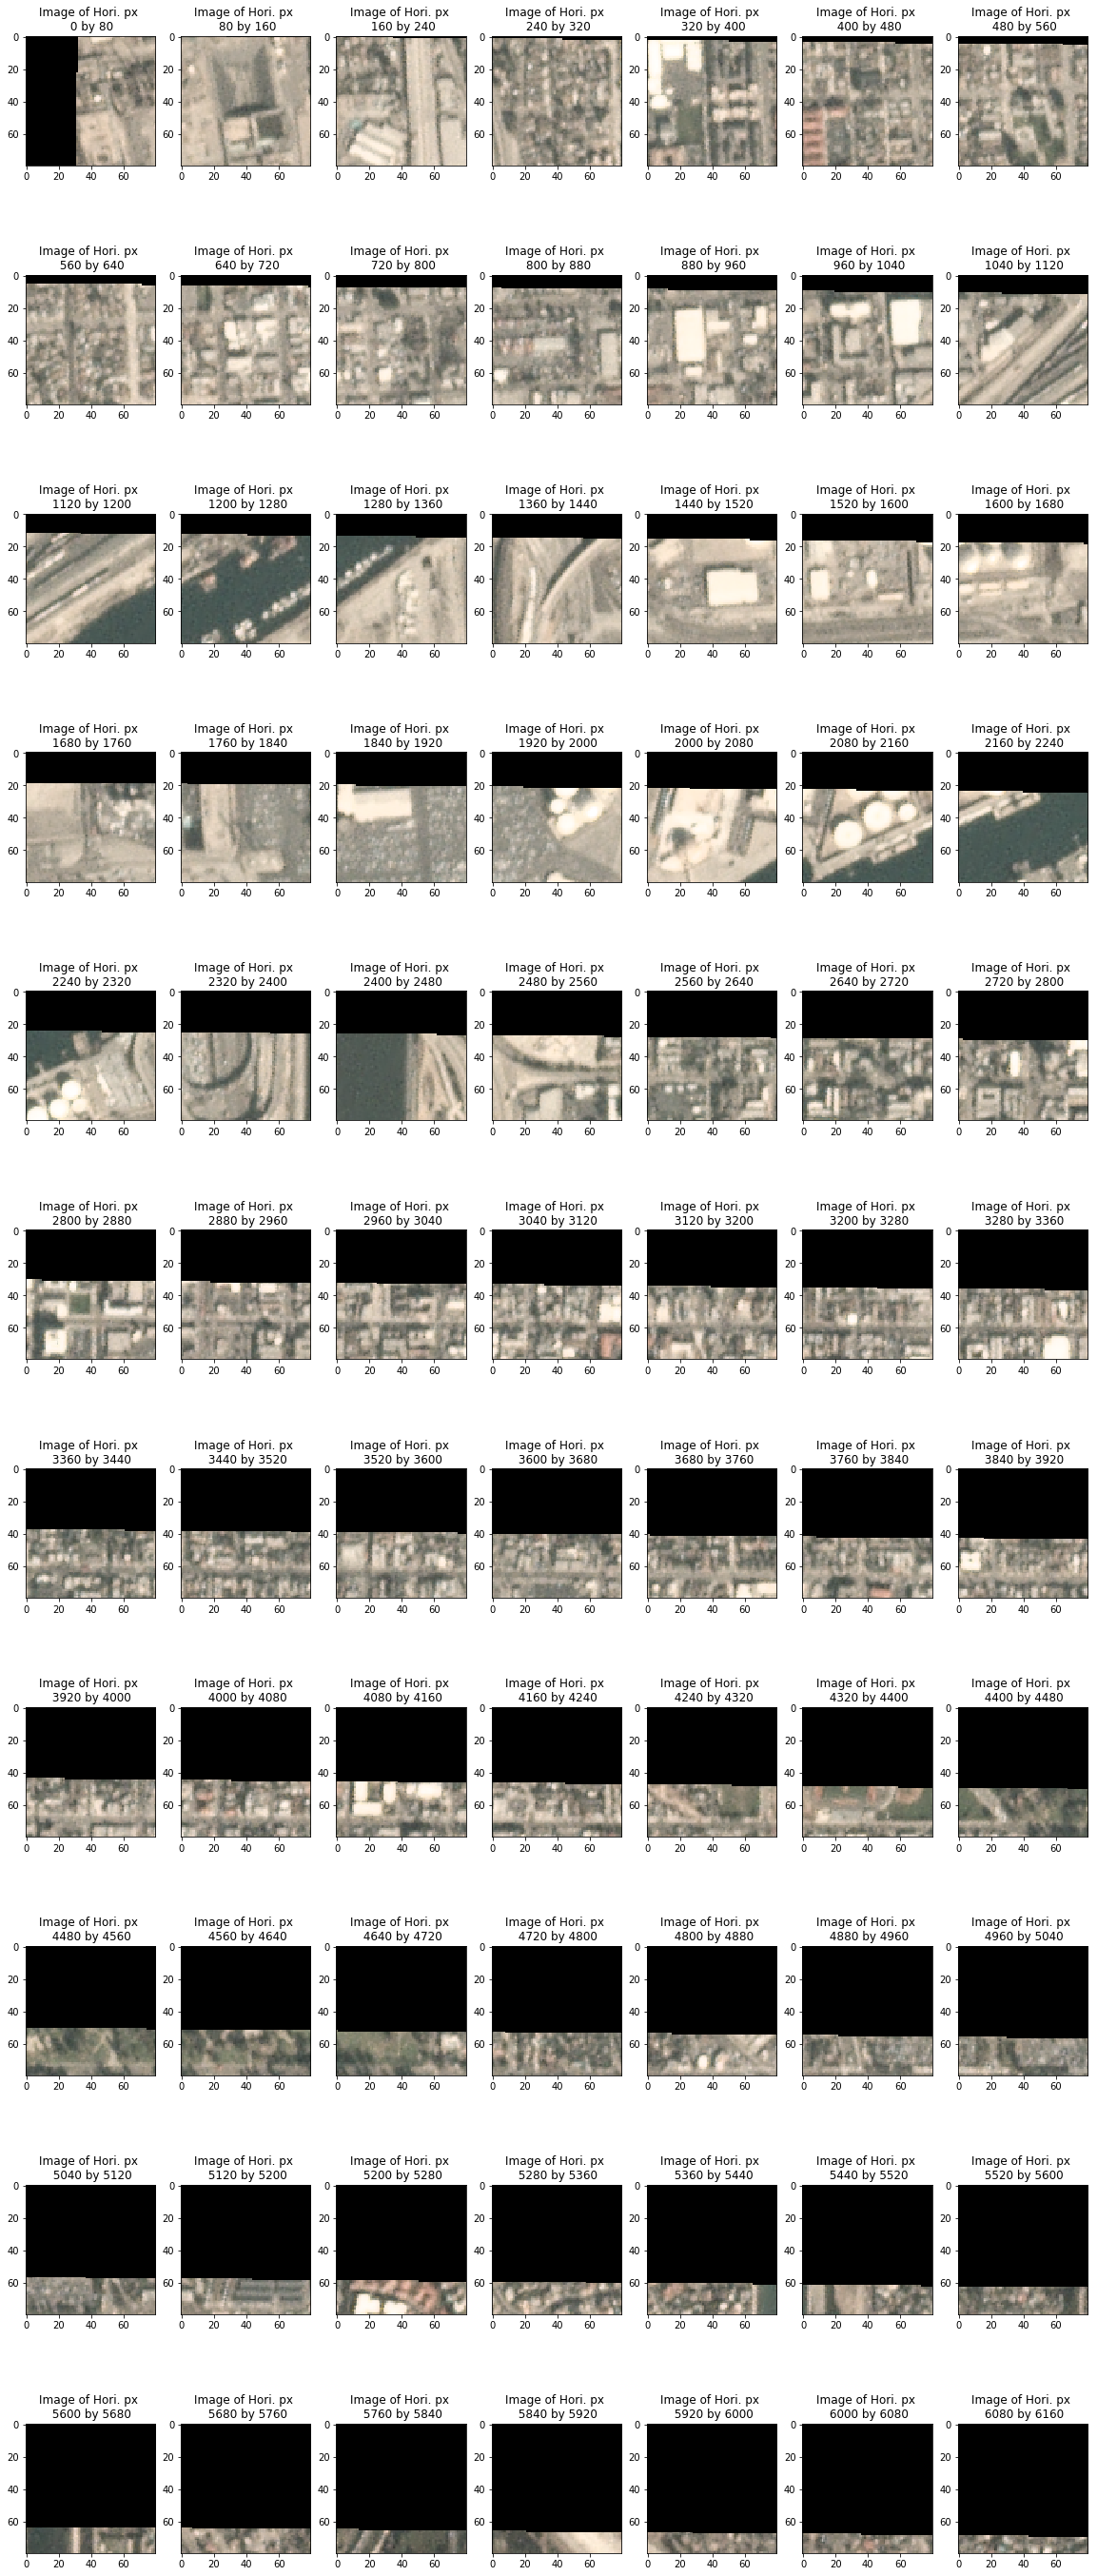

In [17]:
# Looks pretty good, now to try the horizontal:
fig, axes = plt.subplots(11, 7)
fig.set_figheight(50)
fig.set_figwidth(20)
png1_3 = png1[0:3]
mn = 0
mx = mn+80
for i in range(11):
    for j in range(7):
        axes[i,j].imshow(np.dstack(png1_3[0:3,0:80,mn:mx]))
        axes[i,j].set_title('Image of Hori. px \n {} by {}'.format(mn,mx))
        mn += 80
        mx = mn+80

#plt.tight_layout()
plt.show()

A model was train in a Google colab setting and saved as a .h5 file.

We pass the 80x80 square images through to this model. 

We do this for all squares and find the ones that have the highest predictive value for the ship category. 

First, let's load the model and run the test on a sample image:

In [19]:
# Load model
from imageai.Prediction.Custom import CustomImagePrediction
prediction = CustomImagePrediction()
prediction.setModelTypeAsResNet()
prediction.setModelPath(path+"model_ex-020_acc-0.933806.h5")
prediction.setJsonPath(path+"model1_class.json")
prediction.loadModel(num_objects=2)

In [5]:
# Load .png image
import imageio
im = imageio.imread(path+'images//full_png_imgs//'+POLA_tifs[0][0:-4]+'.png')

In [6]:
# This has the layers in the last index:
im.shape

(2623, 6186, 4)

In [116]:
# Unlike the rasterio image from before:
png1.shape

(4, 2623, 6186)

In [118]:
# Ran the model on the top left corner of the image
predictions, probabilities = prediction.predictImage(im[0:80,0:80,0:3], result_count=2, input_type='array')

In [119]:
# Two prediction classes
predictions

['not_ship', 'ship']

In [120]:
# And their probabilities
probabilities

['99.98980760574341', '0.01019368355628103']

In [7]:
# Let's now divide the image into the 80x80 squares:
# Make a list of the images (numpy array format):
im_list = []
coords_list = []
mn_y = 0
mx_y = 80
for y_num in range(32):
    # Set the x coords back to beginning for each y-loop
    mn_x = 0
    mx_x = 80
    for x_num in range(77):
        # Run through the x-coords for each x-loop
        im_list.append(im[mn_y:mx_y, mn_x:mx_x, 0:3])
        coords_list.append(((mn_y,mx_y),(mn_x,mx_x)))
        mn_x += 80
        mx_x = mn_x + 80
    mn_y += 80
    mx_y = mn_y + 80

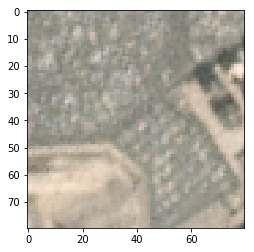

In [8]:
# See what one of these squares looks like
plt.figure()
plt.imshow(im_list[100])
plt.show()

Let's run the prediction model on all the 80x80 squares and display the images that have a probability of being a ship above 30%:

In [ ]:
# Run the model on all images in im_list
results_array = prediction.predictMultipleImages(im_list, result_count_per_image=2, input_type='array')

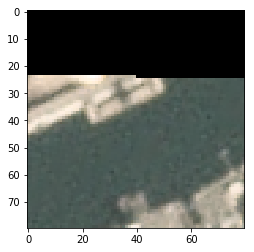

The coordinates for the image are: ((0, 80), (2160, 2240))
-----------------------
not_ship  :  64.46446180343628
-----------------------
ship  :  35.53553819656372
-----------------------






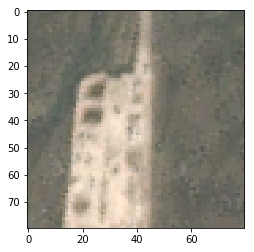

The coordinates for the image are: ((1280, 1360), (6080, 6160))
-----------------------
ship  :  62.982797622680664
-----------------------
not_ship  :  37.01720833778381
-----------------------






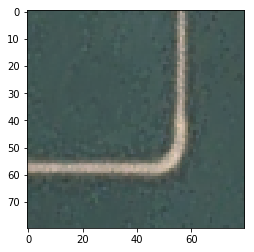

The coordinates for the image are: ((1440, 1520), (3040, 3120))
-----------------------
not_ship  :  59.867388010025024
-----------------------
ship  :  40.132614970207214
-----------------------






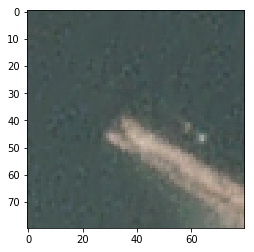

The coordinates for the image are: ((1520, 1600), (5680, 5760))
-----------------------
not_ship  :  67.70979166030884
-----------------------
ship  :  32.29021430015564
-----------------------






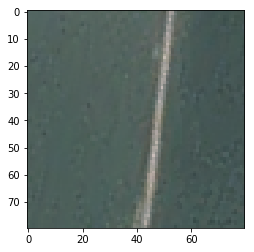

The coordinates for the image are: ((1600, 1680), (5440, 5520))
-----------------------
not_ship  :  69.94999051094055
-----------------------
ship  :  30.05000650882721
-----------------------






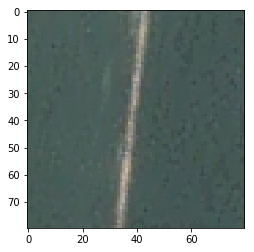

The coordinates for the image are: ((1680, 1760), (5440, 5520))
-----------------------
ship  :  50.26631951332092
-----------------------
not_ship  :  49.73368048667908
-----------------------






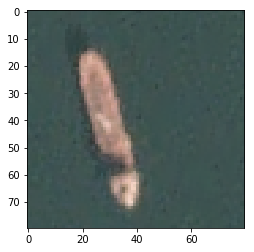

The coordinates for the image are: ((1760, 1840), (3840, 3920))
-----------------------
ship  :  93.05551052093506
-----------------------
not_ship  :  6.944485753774643
-----------------------






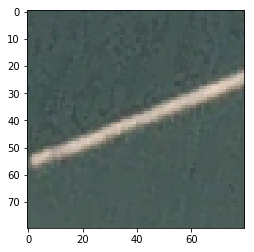

The coordinates for the image are: ((1760, 1840), (5520, 5600))
-----------------------
not_ship  :  56.68502449989319
-----------------------
ship  :  43.31497848033905
-----------------------






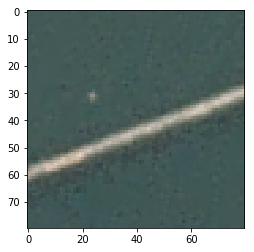

The coordinates for the image are: ((1920, 2000), (2160, 2240))
-----------------------
not_ship  :  57.885003089904785
-----------------------
ship  :  42.114993929862976
-----------------------






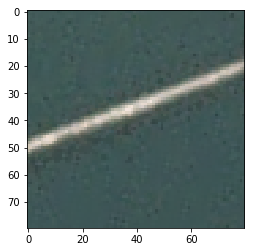

The coordinates for the image are: ((2080, 2160), (1760, 1840))
-----------------------
not_ship  :  54.2300820350647
-----------------------
ship  :  45.76992690563202
-----------------------






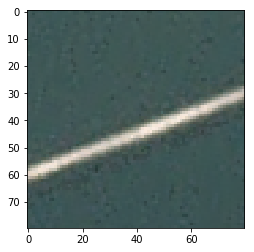

The coordinates for the image are: ((2160, 2240), (1520, 1600))
-----------------------
ship  :  58.562612533569336
-----------------------
not_ship  :  41.437387466430664
-----------------------






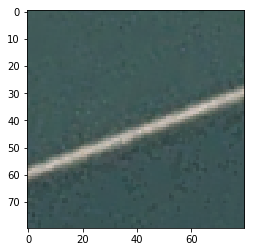

The coordinates for the image are: ((2400, 2480), (880, 960))
-----------------------
not_ship  :  60.928791761398315
-----------------------
ship  :  39.071205258369446
-----------------------






In [152]:
# Display the image and coordinates for those above 30%
for i,each_result in enumerate(results_array):
    predictions, percentage_probabilities = each_result["predictions"], each_result["percentage_probabilities"]
    prob_dict = {}
    for key,val in zip(each_result['predictions'],each_result['percentage_probabilities']):
        prob_dict[key]=val
    # Show the images which have a ship probability greater than 30:
    if float(prob_dict['ship']) > 30:
        plt.figure()
        plt.imshow(im_list[i])
        plt.show()
        print(f'The coordinates for the image are: {coords_list[i]}')
        print("-----------------------")
        for index in range(len(predictions)):
            print(predictions[index] , " : " , percentage_probabilities[index])
            print("-----------------------")
        print('\n\n\n')

We successfully found one ship, however, it doesn't seem to be picking up any edges of ships and there are certainly more.

We will need to alter the searching process.

First, lets see if it can pick up something that is certainly a ship and then alter the coordinates to display on a part:

In [131]:
predictions, probabilities = prediction.predictImage(im[1960:2040,1680:1760,0:3], result_count=2, input_type='array')

In [132]:
predictions

['ship', 'not_ship']

In [133]:
probabilities

['96.1920976638794', '3.8078993558883667']

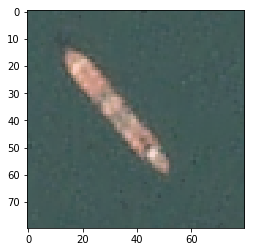

In [134]:
plt.figure()
plt.imshow(im[1960:2040,1680:1760,0:3])
plt.show()

Well over 90%, but what if we could only see a portion of it?

The data was therefore then separated into 3 classes: no_ship, partial_ship and ship.

To increase the size of the data set, we will rotate and change the brightness/sharpness of the image to enable more samples to be fed into the training of the model.

First, we run the image alterations on a test image:

In [ ]:
# Load image
from PIL import Image
ship_path = 'ships-in-satellite-imagery//shipsnet//ships//'
ship1 = Image.open(path+ship_path+'1__20180712_180755_0f2d__-118.15166889302655_33.73582571921725'+'.png')

In [10]:
# Rotate it by 180 degrees
rotated     = ship1.rotate(180)

# Rotate it by 90 degrees
transposed  = ship1.transpose(Image.ROTATE_90)

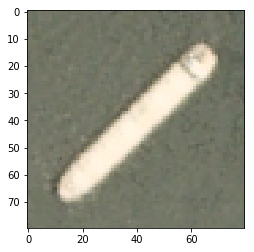

In [40]:
# Display the Original Image
plt.imshow(np.asarray(ship1))
plt.show()

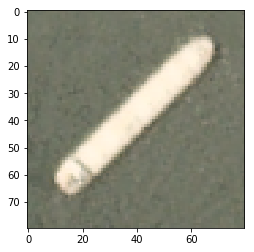

In [29]:
# Display the Image rotated by 180 degrees
plt.imshow(np.asarray(rotated))
plt.show()

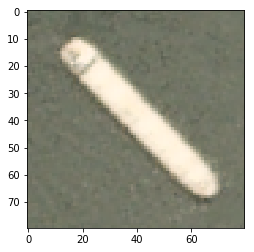

In [30]:
# Display the Image rotated by 90 degrees
plt.imshow(np.asarray(transposed))
plt.show()

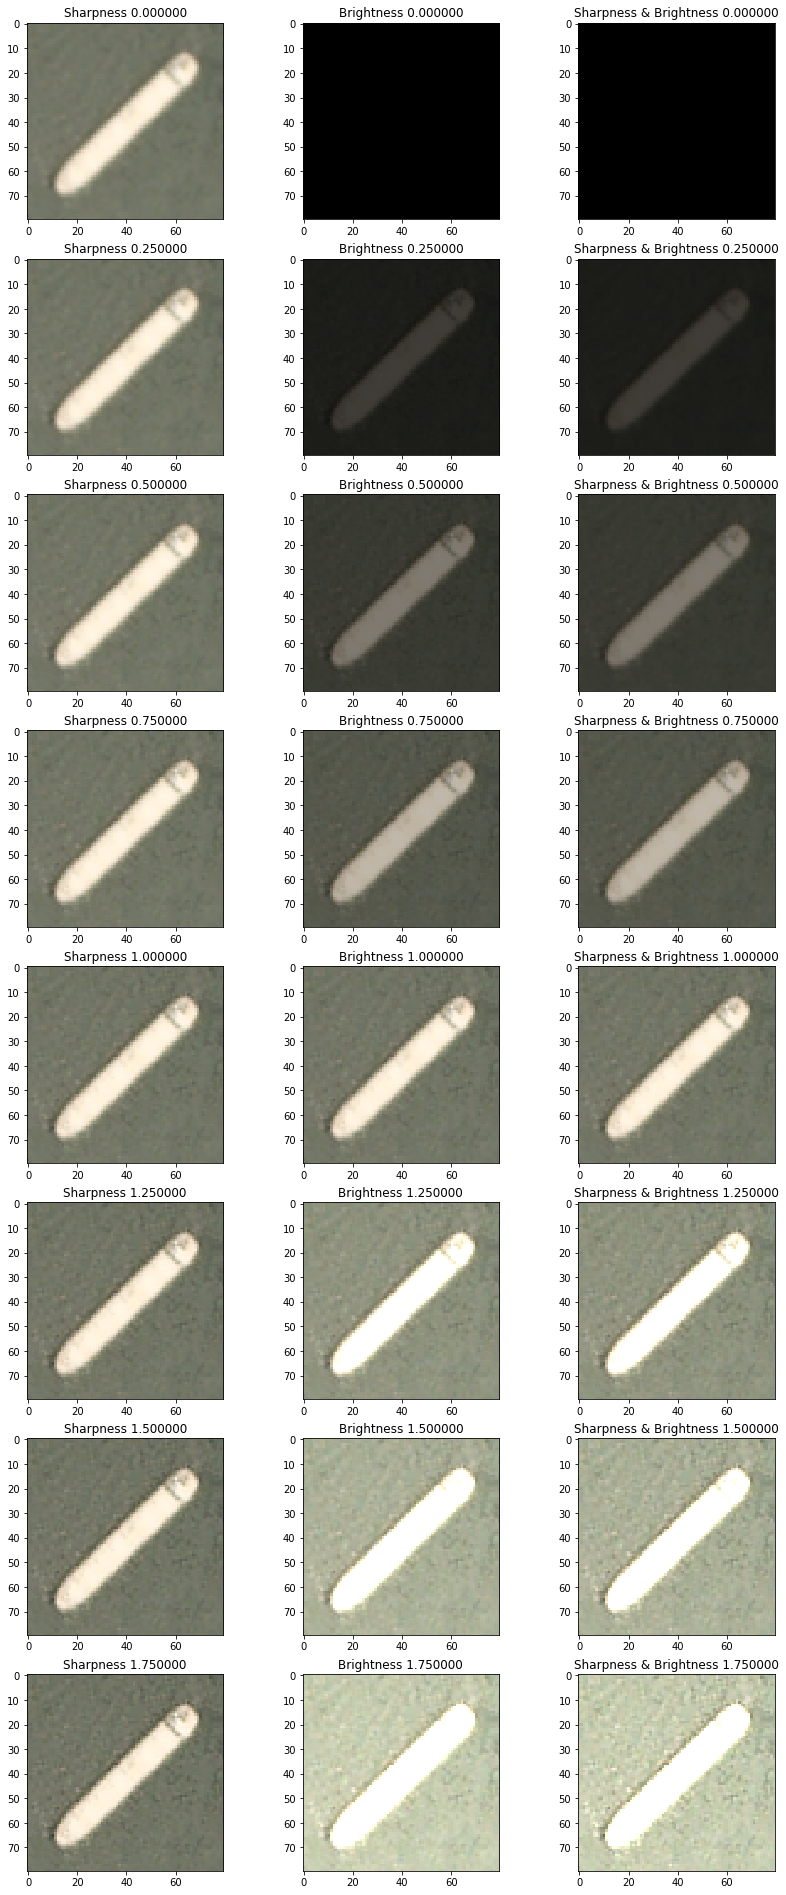

In [41]:
# Lets look at brightness and sharpness changes:

from PIL import ImageEnhance

sharp_enhancer = ImageEnhance.Sharpness(ship1)
bright_enhancer = ImageEnhance.Brightness(ship1)

fig, axes = plt.subplots(8, 3)
fig.set_figheight(34)
fig.set_figwidth(14)

for i in range(8):
    factor = i / 4.0
    sharp_im = sharp_enhancer.enhance(factor)
    bright_im = bright_enhancer.enhance(factor)
    sharp_bright_en = ImageEnhance.Brightness(sharp_im)
    axes[i,0].imshow(np.asarray(sharp_im))
    axes[i,0].set_title("Sharpness %f" % factor)
    axes[i,1].imshow(np.asarray(bright_im))
    axes[i,1].set_title("Brightness %f" % factor)
    axes[i,2].imshow(np.asarray(sharp_bright_en.enhance(factor)))
    axes[i,2].set_title("Sharpness & Brightness %f" % factor)
    plt.imshow
plt.show()

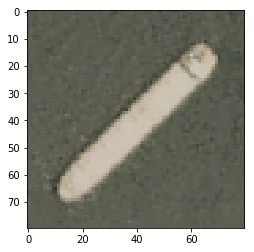

In [47]:
eg = sharp_bright_en.enhance(0.8)
plt.imshow(np.asarray(eg))

In [67]:
eg.save(eg_path.parent.joinpath(eg_path.parts[-1][0:-4]+'_1.png'))

What we will do now is quadruple our dataset by creating three different versions of each existing image:
- one with the sharpness increased by 1.75, brightness at 1.1 and rotated 90 degrees
- one with sharpness 0.50, brightness 0.75 and rotated 180 degrees
- and one with sharpness 1.20, brightness 0.85 and rotated 270 degrees


In [71]:
from pathlib import Path
from PIL import Image

In [74]:
# Path to images
ships_str = '..//ships_sat2//'
ships_path = Path(ships_str)

# Find all png files:
png_gen = ships_path.glob('**/*.png')

# Make it a list so it can be re-used
png_list = list(png_gen)

def rot_sharp_bri_im(rot, sha, bri, list_paths, suff, form): 
    # Rotation, sharpness, brightness factors, path to images and suffix string
    
    # Run through the generator created and carry out image changes
    for im_path in list_paths:
        with Image.open(im_path) as im:
            # Rotate
            rot_im = im.rotate(rot)
            # Increase sharpness
            sharp_enhancer = ImageEnhance.Sharpness(rot_im)
            sharp_im = sharp_enhancer.enhance(sha)
            # Increase brightness
            bright_enhancer = ImageEnhance.Brightness(sharp_im)
            fin_im = bright_enhancer.enhance(bri)
            # Create path to save image in the same folder but with an added suffix to the original name:
            fin_path = im_path.parent.joinpath(im_path.parts[-1][0:-4]+suff+form)
            # Save file:
            fin_im.save(fin_path)

In [75]:
# Rotate all images by 90 degrees, increase sharpness to 1.75 and brightness to 1.1:
rot_sharp_bri_im(90, 1.75, 1.1, png_list, '_09', '.png')

In [76]:
# Rotate all images by 180 degrees, increase sharpness to 1.75 and brightness to 1.1:
rot_sharp_bri_im(180, 0.5, 0.75, png_list, '_18', '.png')

In [77]:
# Rotate all images by 270 degrees, increase sharpness to 1.2 and brightness to 0.85:
rot_sharp_bri_im(270, 1.2, 0.85, png_list, '_27', '.png')

This is now ready to be re-run in the Google Colab notebook to create the model.

Once this was carried out, the new model was saved and will be used to run the searching process again below:

In [9]:
# Load model
from imageai.Prediction.Custom import CustomImagePrediction
prediction2 = CustomImagePrediction()
prediction2.setModelTypeAsResNet()
prediction2.setModelPath(path+"model2_ex-017_acc-0.933806.h5")
prediction2.setJsonPath(path+"model2_class.json")
prediction2.loadModel(num_objects=3)

In [ ]:
# Run the model on all images in im_list and time how long it takes
import datetime

start = datetime.datetime.now()
results_array2 = prediction2.predictMultipleImages(im_list, result_count_per_image=3, input_type='array')
end = datetime.datetime.now()
comp_time = end-start

In [11]:
print(f'The time taken to search all the sqaures in the image is: {comp_time}')

The time taken to search all the sqaures in the image is: 0:18:49.374068


The images with ship probabilities above 95% are: 



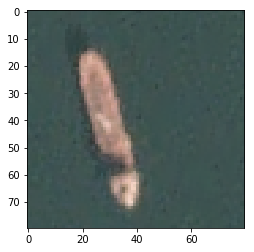

The coordinates for the image are: ((1760, 1840), (3840, 3920))
-----------------------
ship  :  98.33118915557861
-----------------------
partial_ship  :  1.0195263661444187
-----------------------
not_ship  :  0.6492882501333952
-----------------------







The images with partial-ship probabilities above 95% are:


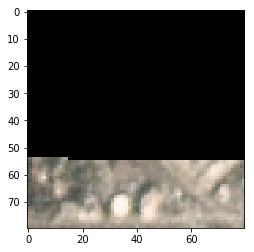

The coordinates for the image are: ((0, 80), (4800, 4880))
-----------------------
partial_ship  :  95.75897455215454
-----------------------
not_ship  :  4.235970973968506
-----------------------
ship  :  0.005051554762758315
-----------------------





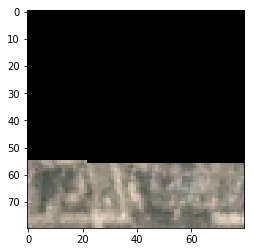

The coordinates for the image are: ((0, 80), (4880, 4960))
-----------------------
partial_ship  :  98.35922718048096
-----------------------
not_ship  :  1.6366999596357346
-----------------------
ship  :  0.004072995943715796
-----------------------





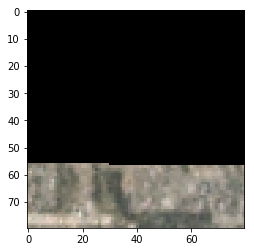

The coordinates for the image are: ((0, 80), (4960, 5040))
-----------------------
partial_ship  :  98.982834815979
-----------------------
not_ship  :  1.011110097169876
-----------------------
ship  :  0.006050132651580498
-----------------------





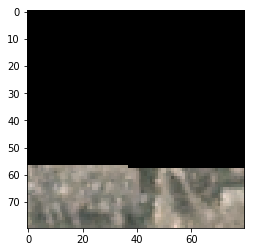

The coordinates for the image are: ((0, 80), (5040, 5120))
-----------------------
partial_ship  :  98.92386198043823
-----------------------
not_ship  :  1.072381716221571
-----------------------
ship  :  0.0037562946090474725
-----------------------





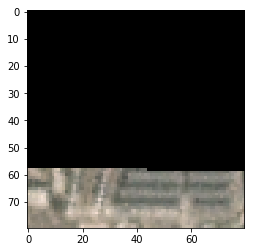

The coordinates for the image are: ((0, 80), (5120, 5200))
-----------------------
partial_ship  :  99.62990880012512
-----------------------
not_ship  :  0.3686069278046489
-----------------------
ship  :  0.0014807956176809967
-----------------------





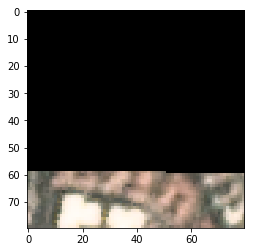

The coordinates for the image are: ((0, 80), (5200, 5280))
-----------------------
partial_ship  :  99.80345368385315
-----------------------
not_ship  :  0.19593925680965185
-----------------------
ship  :  0.0006117358225310454
-----------------------





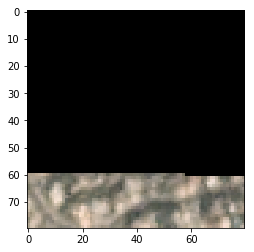

The coordinates for the image are: ((0, 80), (5280, 5360))
-----------------------
partial_ship  :  99.43369030952454
-----------------------
not_ship  :  0.5655107088387012
-----------------------
ship  :  0.0007910789463494439
-----------------------





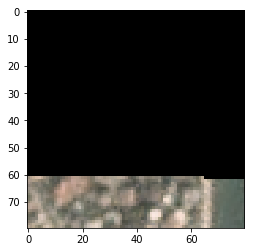

The coordinates for the image are: ((0, 80), (5360, 5440))
-----------------------
partial_ship  :  99.60483908653259
-----------------------
not_ship  :  0.3941241651773453
-----------------------
ship  :  0.0010324300092179328
-----------------------





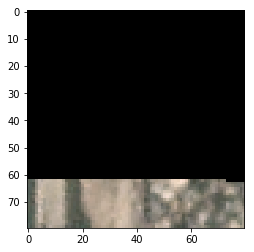

The coordinates for the image are: ((0, 80), (5440, 5520))
-----------------------
partial_ship  :  99.62792992591858
-----------------------
not_ship  :  0.37111807614564896
-----------------------
ship  :  0.000953748713072855
-----------------------





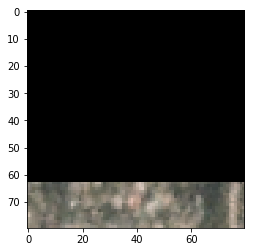

The coordinates for the image are: ((0, 80), (5520, 5600))
-----------------------
partial_ship  :  98.3671486377716
-----------------------
not_ship  :  1.6290204599499702
-----------------------
ship  :  0.0038396530726458877
-----------------------





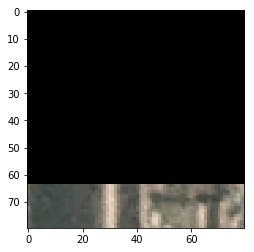

The coordinates for the image are: ((0, 80), (5600, 5680))
-----------------------
partial_ship  :  97.79624938964844
-----------------------
not_ship  :  2.199809066951275
-----------------------
ship  :  0.003943130286643282
-----------------------





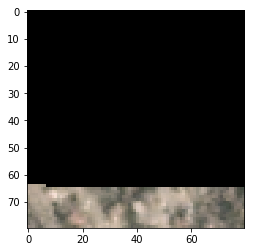

The coordinates for the image are: ((0, 80), (5680, 5760))
-----------------------
partial_ship  :  99.51663017272949
-----------------------
not_ship  :  0.48197750002145767
-----------------------
ship  :  0.0013870583643438295
-----------------------





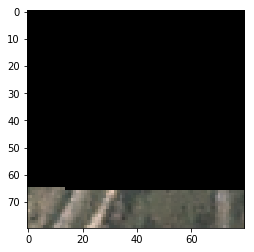

The coordinates for the image are: ((0, 80), (5760, 5840))
-----------------------
partial_ship  :  95.82512378692627
-----------------------
not_ship  :  4.170441627502441
-----------------------
ship  :  0.0044332984543871135
-----------------------





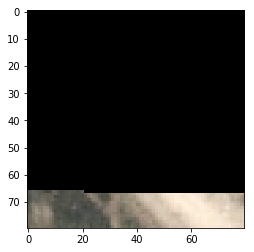

The coordinates for the image are: ((0, 80), (5840, 5920))
-----------------------
partial_ship  :  99.50119256973267
-----------------------
not_ship  :  0.49522663466632366
-----------------------
ship  :  0.00358198449248448
-----------------------





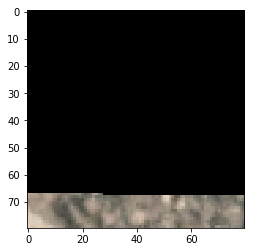

The coordinates for the image are: ((0, 80), (5920, 6000))
-----------------------
partial_ship  :  98.81537556648254
-----------------------
not_ship  :  1.1811304837465286
-----------------------
ship  :  0.0034999477065866813
-----------------------





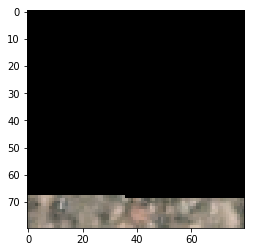

The coordinates for the image are: ((0, 80), (6000, 6080))
-----------------------
partial_ship  :  99.17003512382507
-----------------------
not_ship  :  0.8279129862785339
-----------------------
ship  :  0.002039887294813525
-----------------------





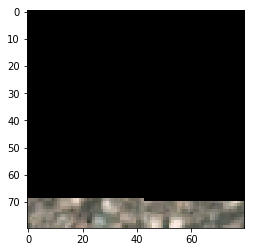

The coordinates for the image are: ((0, 80), (6080, 6160))
-----------------------
partial_ship  :  98.9930272102356
-----------------------
not_ship  :  1.0045344941318035
-----------------------
ship  :  0.002425479397061281
-----------------------





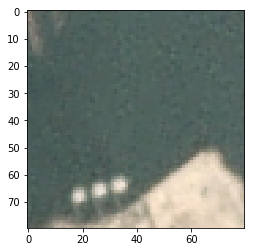

The coordinates for the image are: ((240, 320), (1760, 1840))
-----------------------
partial_ship  :  98.77217411994934
-----------------------
not_ship  :  1.213530544191599
-----------------------
ship  :  0.0142993128974922
-----------------------





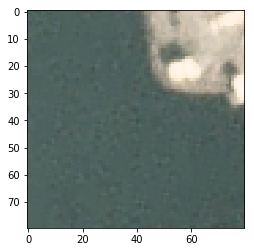

The coordinates for the image are: ((240, 320), (1920, 2000))
-----------------------
partial_ship  :  96.12980484962463
-----------------------
not_ship  :  3.868744894862175
-----------------------
ship  :  0.0014445681699726265
-----------------------





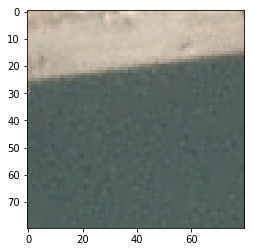

The coordinates for the image are: ((320, 400), (320, 400))
-----------------------
partial_ship  :  96.20996117591858
-----------------------
not_ship  :  3.789951279759407
-----------------------
ship  :  9.669304290582659e-05
-----------------------





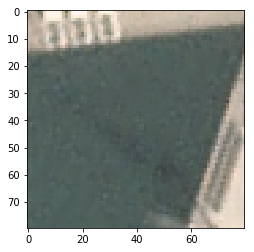

The coordinates for the image are: ((320, 400), (400, 480))
-----------------------
partial_ship  :  99.4127869606018
-----------------------
not_ship  :  0.5871916655451059
-----------------------
ship  :  2.1695828422707564e-05
-----------------------





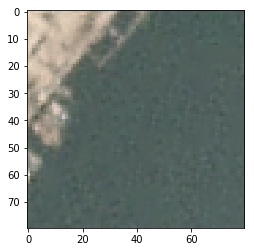

The coordinates for the image are: ((400, 480), (880, 960))
-----------------------
partial_ship  :  97.1880555152893
-----------------------
not_ship  :  2.8117669746279716
-----------------------
ship  :  0.0001802552674234903
-----------------------





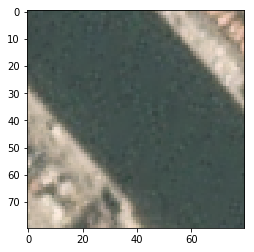

The coordinates for the image are: ((400, 480), (4720, 4800))
-----------------------
partial_ship  :  99.92610812187195
-----------------------
not_ship  :  0.07386503857560456
-----------------------
ship  :  2.0121036925502267e-05
-----------------------





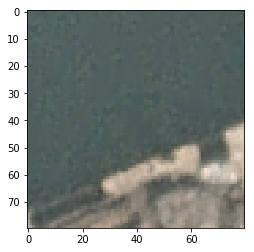

The coordinates for the image are: ((480, 560), (960, 1040))
-----------------------
partial_ship  :  96.47963643074036
-----------------------
not_ship  :  3.4981779754161835
-----------------------
ship  :  0.022181881649885327
-----------------------





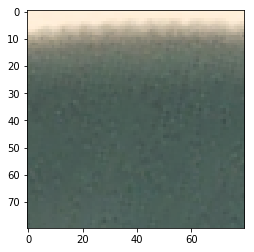

The coordinates for the image are: ((480, 560), (3200, 3280))
-----------------------
partial_ship  :  96.89397811889648
-----------------------
not_ship  :  3.1059756875038147
-----------------------
ship  :  4.431498439316783e-05
-----------------------





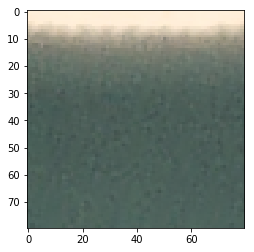

The coordinates for the image are: ((480, 560), (3280, 3360))
-----------------------
partial_ship  :  96.75346612930298
-----------------------
not_ship  :  3.2464858144521713
-----------------------
ship  :  4.9970253712672275e-05
-----------------------





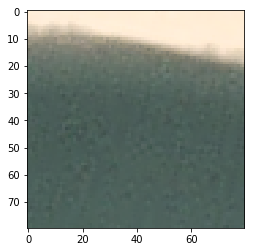

The coordinates for the image are: ((480, 560), (3360, 3440))
-----------------------
partial_ship  :  97.05021381378174
-----------------------
not_ship  :  2.949674613773823
-----------------------
ship  :  0.00011427589470258681
-----------------------





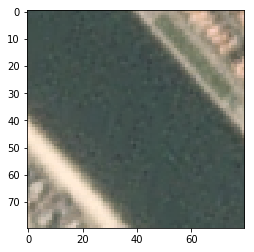

The coordinates for the image are: ((480, 560), (4800, 4880))
-----------------------
partial_ship  :  99.88899827003479
-----------------------
not_ship  :  0.11080045951530337
-----------------------
ship  :  0.00020033994587720372
-----------------------





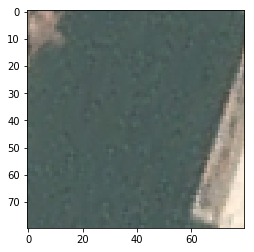

The coordinates for the image are: ((560, 640), (320, 400))
-----------------------
partial_ship  :  98.80109429359436
-----------------------
not_ship  :  1.1972994543612003
-----------------------
ship  :  0.0016073154256446287
-----------------------





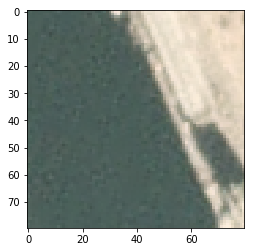

The coordinates for the image are: ((560, 640), (2000, 2080))
-----------------------
partial_ship  :  96.0419237613678
-----------------------
not_ship  :  3.9563536643981934
-----------------------
ship  :  0.001716519363981206
-----------------------





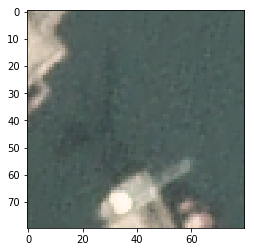

The coordinates for the image are: ((640, 720), (240, 320))
-----------------------
partial_ship  :  98.28048348426819
-----------------------
not_ship  :  1.7085468396544456
-----------------------
ship  :  0.010971698065986857
-----------------------





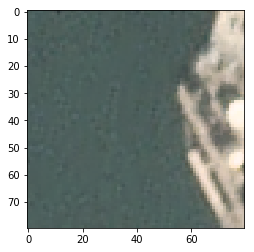

The coordinates for the image are: ((640, 720), (320, 400))
-----------------------
partial_ship  :  97.13250398635864
-----------------------
not_ship  :  2.8624482452869415
-----------------------
ship  :  0.005050565232522786
-----------------------





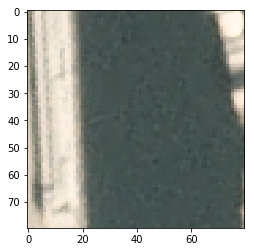

The coordinates for the image are: ((640, 720), (480, 560))
-----------------------
partial_ship  :  99.65484738349915
-----------------------
not_ship  :  0.3451559692621231
-----------------------
ship  :  5.312503859045137e-06
-----------------------





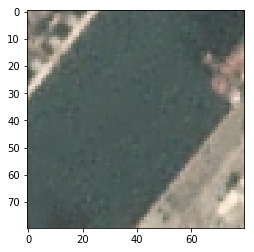

The coordinates for the image are: ((640, 720), (720, 800))
-----------------------
partial_ship  :  99.79623556137085
-----------------------
not_ship  :  0.20344085060060024
-----------------------
ship  :  0.00031972117540135514
-----------------------





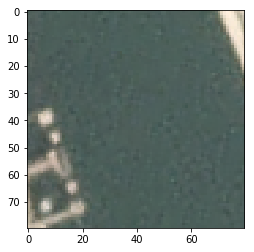

The coordinates for the image are: ((640, 720), (2000, 2080))
-----------------------
partial_ship  :  99.61850047111511
-----------------------
not_ship  :  0.3814533818513155
-----------------------
ship  :  4.6738935566281725e-05
-----------------------





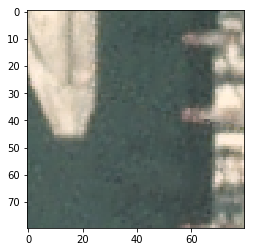

The coordinates for the image are: ((640, 720), (2080, 2160))
-----------------------
partial_ship  :  97.68373370170593
-----------------------
not_ship  :  2.316064015030861
-----------------------
ship  :  0.00021484258923010202
-----------------------





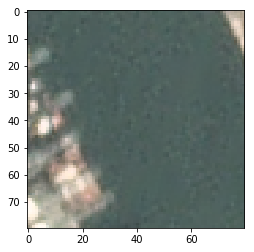

The coordinates for the image are: ((720, 800), (320, 400))
-----------------------
partial_ship  :  99.59571957588196
-----------------------
not_ship  :  0.4042109940201044
-----------------------
ship  :  6.99942461324099e-05
-----------------------





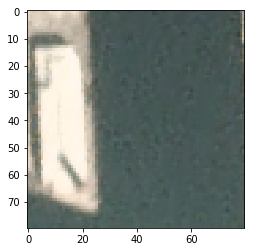

The coordinates for the image are: ((720, 800), (480, 560))
-----------------------
partial_ship  :  96.82355523109436
-----------------------
not_ship  :  3.176213428378105
-----------------------
ship  :  0.00023171162411017576
-----------------------





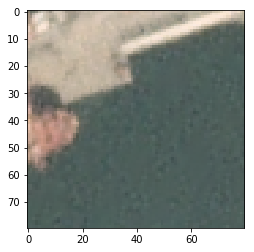

The coordinates for the image are: ((720, 800), (1680, 1760))
-----------------------
partial_ship  :  95.35499811172485
-----------------------
not_ship  :  4.6448662877082825
-----------------------
ship  :  0.00013810215477860766
-----------------------





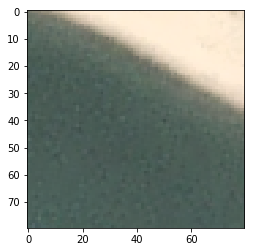

The coordinates for the image are: ((720, 800), (4160, 4240))
-----------------------
partial_ship  :  95.71961760520935
-----------------------
not_ship  :  4.279926419258118
-----------------------
ship  :  0.0004562617959891213
-----------------------





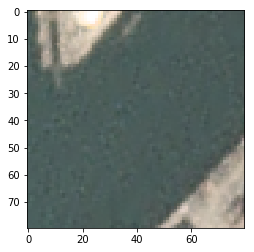

The coordinates for the image are: ((800, 880), (560, 640))
-----------------------
partial_ship  :  99.94454979896545
-----------------------
not_ship  :  0.055368547327816486
-----------------------
ship  :  8.360248102690093e-05
-----------------------





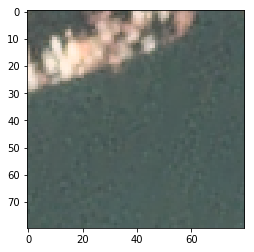

The coordinates for the image are: ((800, 880), (1520, 1600))
-----------------------
partial_ship  :  97.85192608833313
-----------------------
not_ship  :  2.1463561803102493
-----------------------
ship  :  0.0017175552784465253
-----------------------





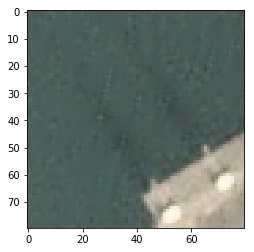

The coordinates for the image are: ((800, 880), (2080, 2160))
-----------------------
partial_ship  :  97.28015661239624
-----------------------
not_ship  :  2.705615572631359
-----------------------
ship  :  0.014228057989384979
-----------------------





The coordinates for the image are: ((800, 880), (3680, 3760))
-----------------------
partial_ship  :  98.3658492565155
-----------------------
not_ship  :  1.618272252380848
-----------------------
ship  :  0.01587594742886722
-----------------------





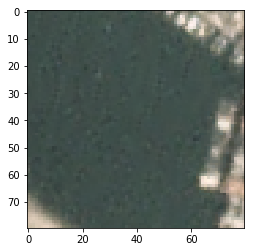

The coordinates for the image are: ((800, 880), (4640, 4720))
-----------------------
partial_ship  :  99.28077459335327
-----------------------
not_ship  :  0.7190712261945009
-----------------------
ship  :  0.00015765550642754533
-----------------------





The coordinates for the image are: ((880, 960), (1280, 1360))
-----------------------
partial_ship  :  96.93100452423096
-----------------------
not_ship  :  3.068901039659977
-----------------------
ship  :  8.949530752033752e-05
-----------------------





The coordinates for the image are: ((880, 960), (4960, 5040))
-----------------------
partial_ship  :  97.8276789188385
-----------------------
not_ship  :  2.172236889600754
-----------------------
ship  :  8.460095841655857e-05
-----------------------





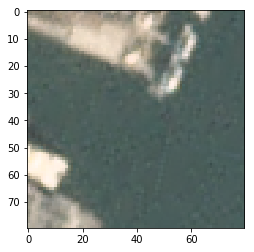

The coordinates for the image are: ((960, 1040), (320, 400))
-----------------------
partial_ship  :  98.22835326194763
-----------------------
not_ship  :  1.769723929464817
-----------------------
ship  :  0.0019231358237448148
-----------------------





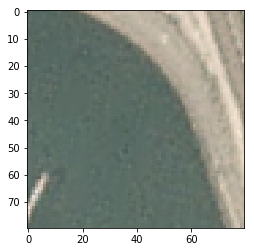

The coordinates for the image are: ((960, 1040), (1120, 1200))
-----------------------
partial_ship  :  99.02327060699463
-----------------------
not_ship  :  0.9765824303030968
-----------------------
ship  :  0.00014254983398132026
-----------------------





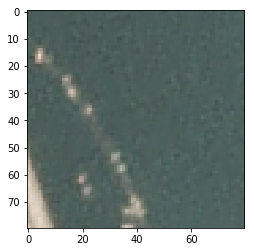

The coordinates for the image are: ((960, 1040), (1280, 1360))
-----------------------
partial_ship  :  96.64990901947021
-----------------------
not_ship  :  3.3371996134519577
-----------------------
ship  :  0.012895952386315912
-----------------------





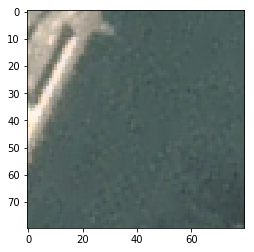

The coordinates for the image are: ((1040, 1120), (320, 400))
-----------------------
partial_ship  :  96.89726829528809
-----------------------
not_ship  :  3.102412261068821
-----------------------
ship  :  0.00030833875825919677
-----------------------





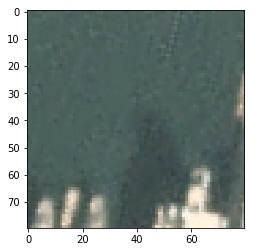

The coordinates for the image are: ((1040, 1120), (1760, 1840))
-----------------------
partial_ship  :  99.30504560470581
-----------------------
not_ship  :  0.6911520846188068
-----------------------
ship  :  0.003805122833000496
-----------------------





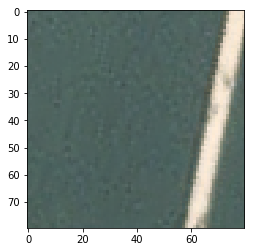

The coordinates for the image are: ((1120, 1200), (1520, 1600))
-----------------------
partial_ship  :  95.4533338546753
-----------------------
not_ship  :  4.530571773648262
-----------------------
ship  :  0.01609043829375878
-----------------------





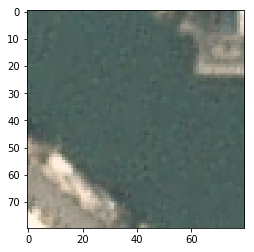

The coordinates for the image are: ((1120, 1200), (2320, 2400))
-----------------------
partial_ship  :  99.86068606376648
-----------------------
not_ship  :  0.13923841761425138
-----------------------
ship  :  7.896096576587297e-05
-----------------------





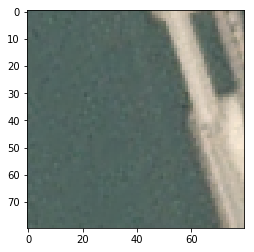

The coordinates for the image are: ((1200, 1280), (1200, 1280))
-----------------------
partial_ship  :  97.76026606559753
-----------------------
not_ship  :  2.2382475435733795
-----------------------
ship  :  0.001488473208155483
-----------------------





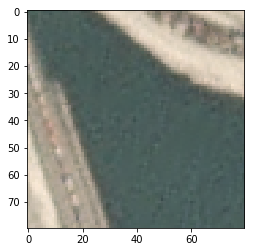

The coordinates for the image are: ((1200, 1280), (1280, 1360))
-----------------------
partial_ship  :  95.52754163742065
-----------------------
not_ship  :  4.471310973167419
-----------------------
ship  :  0.001146264185081236
-----------------------





The coordinates for the image are: ((1200, 1280), (2560, 2640))
-----------------------
partial_ship  :  95.18808722496033
-----------------------
not_ship  :  4.793836921453476
-----------------------
ship  :  0.0180789633304812
-----------------------





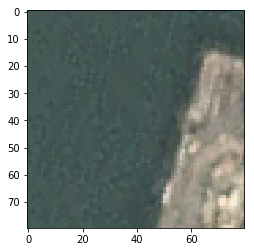

The coordinates for the image are: ((1200, 1280), (3600, 3680))
-----------------------
partial_ship  :  96.54324650764465
-----------------------
not_ship  :  3.422272205352783
-----------------------
ship  :  0.03448442148510367
-----------------------





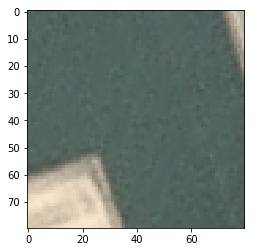

The coordinates for the image are: ((1280, 1360), (1200, 1280))
-----------------------
partial_ship  :  99.64116215705872
-----------------------
not_ship  :  0.358632393181324
-----------------------
ship  :  0.00019709427760972176
-----------------------





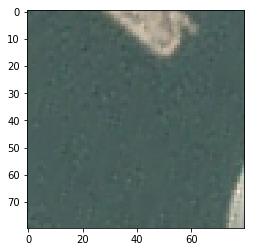

The coordinates for the image are: ((1280, 1360), (2320, 2400))
-----------------------
partial_ship  :  97.04802632331848
-----------------------
not_ship  :  2.951214835047722
-----------------------
ship  :  0.0007616052698722342
-----------------------





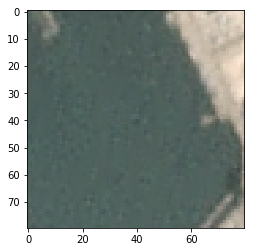

The coordinates for the image are: ((1360, 1440), (560, 640))
-----------------------
partial_ship  :  97.7676272392273
-----------------------
not_ship  :  2.2320758551359177
-----------------------
ship  :  0.0003064179963985225
-----------------------





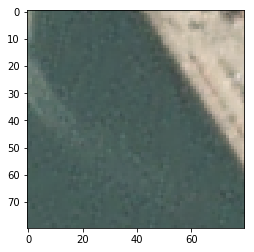

The coordinates for the image are: ((1360, 1440), (2400, 2480))
-----------------------
partial_ship  :  99.18805956840515
-----------------------
not_ship  :  0.8117835968732834
-----------------------
ship  :  0.0001566892024129629
-----------------------





The coordinates for the image are: ((1360, 1440), (2880, 2960))
-----------------------
partial_ship  :  99.60501790046692
-----------------------
not_ship  :  0.39498014375567436
-----------------------
ship  :  1.8360661879768259e-07
-----------------------





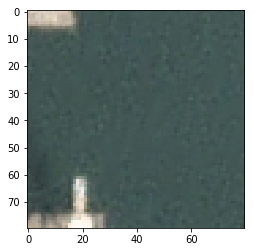

The coordinates for the image are: ((1360, 1440), (2960, 3040))
-----------------------
partial_ship  :  96.98755741119385
-----------------------
not_ship  :  3.0109817162156105
-----------------------
ship  :  0.001451219304726692
-----------------------





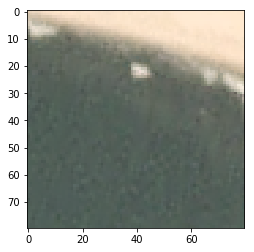

The coordinates for the image are: ((1360, 1440), (5200, 5280))
-----------------------
partial_ship  :  97.36296534538269
-----------------------
not_ship  :  2.6369674131274223
-----------------------
ship  :  7.076417887219577e-05
-----------------------





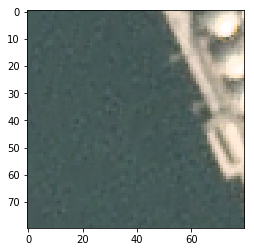

The coordinates for the image are: ((1440, 1520), (320, 400))
-----------------------
partial_ship  :  98.56776595115662
-----------------------
not_ship  :  1.430630125105381
-----------------------
ship  :  0.001596724359842483
-----------------------





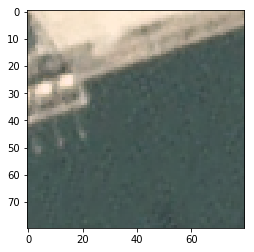

The coordinates for the image are: ((1440, 1520), (1120, 1200))
-----------------------
partial_ship  :  96.02937698364258
-----------------------
not_ship  :  3.9703208953142166
-----------------------
ship  :  0.0002949723466372234
-----------------------





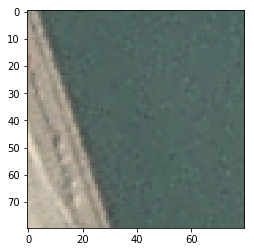

The coordinates for the image are: ((1440, 1520), (1360, 1440))
-----------------------
partial_ship  :  95.87119817733765
-----------------------
not_ship  :  4.127797111868858
-----------------------
ship  :  0.001006721595331328
-----------------------





The coordinates for the image are: ((1440, 1520), (5680, 5760))
-----------------------
partial_ship  :  97.78134822845459
-----------------------
not_ship  :  2.215809002518654
-----------------------
ship  :  0.0028387090424075723
-----------------------





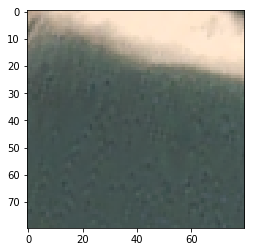

The coordinates for the image are: ((1520, 1600), (5520, 5600))
-----------------------
partial_ship  :  96.68079614639282
-----------------------
not_ship  :  3.3191174268722534
-----------------------
ship  :  8.017495360945759e-05
-----------------------





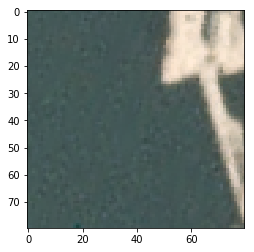

The coordinates for the image are: ((1600, 1680), (400, 480))
-----------------------
partial_ship  :  97.61301875114441
-----------------------
not_ship  :  2.386212535202503
-----------------------
ship  :  0.0007660618393856566
-----------------------





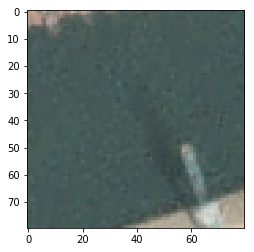

The coordinates for the image are: ((1600, 1680), (800, 880))
-----------------------
partial_ship  :  95.07378339767456
-----------------------
not_ship  :  4.919303208589554
-----------------------
ship  :  0.006908964860485867
-----------------------





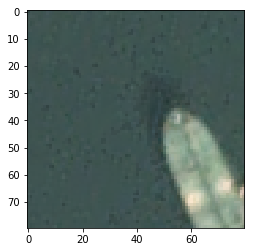

The coordinates for the image are: ((1680, 1760), (3520, 3600))
-----------------------
partial_ship  :  98.32776188850403
-----------------------
not_ship  :  1.6488580033183098
-----------------------
ship  :  0.023371544375550002
-----------------------





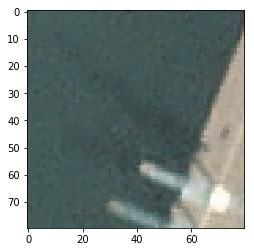

The coordinates for the image are: ((1760, 1840), (720, 800))
-----------------------
partial_ship  :  95.40174007415771
-----------------------
not_ship  :  4.577357694506645
-----------------------
ship  :  0.020905806741211563
-----------------------





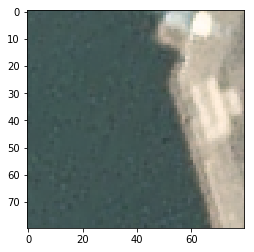

The coordinates for the image are: ((1840, 1920), (720, 800))
-----------------------
partial_ship  :  98.08052778244019
-----------------------
not_ship  :  1.9127802923321724
-----------------------
ship  :  0.006692880560876802
-----------------------





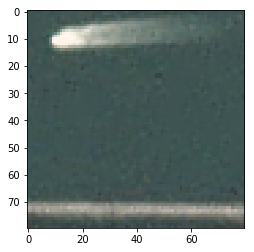

The coordinates for the image are: ((1840, 1920), (3280, 3360))
-----------------------
partial_ship  :  98.43795895576477
-----------------------
not_ship  :  1.5608527697622776
-----------------------
ship  :  0.0011897657714143861
-----------------------





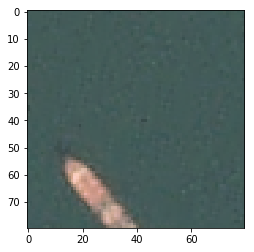

The coordinates for the image are: ((1920, 2000), (1680, 1760))
-----------------------
partial_ship  :  95.63058614730835
-----------------------
not_ship  :  4.315532743930817
-----------------------
ship  :  0.05387405981309712
-----------------------





The coordinates for the image are: ((2000, 2080), (1120, 1200))
-----------------------
partial_ship  :  96.10327482223511
-----------------------
not_ship  :  3.8943231105804443
-----------------------
ship  :  0.002408982618362643
-----------------------





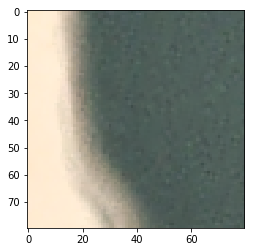

The coordinates for the image are: ((2240, 2320), (80, 160))
-----------------------
partial_ship  :  96.48100137710571
-----------------------
not_ship  :  3.517650067806244
-----------------------
ship  :  0.0013429125829134136
-----------------------





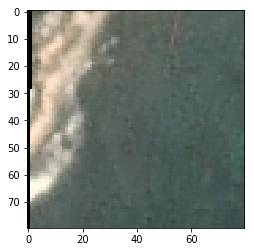

The coordinates for the image are: ((2400, 2480), (0, 80))
-----------------------
partial_ship  :  99.59652423858643
-----------------------
not_ship  :  0.4034309182316065
-----------------------
ship  :  4.488472598040971e-05
-----------------------





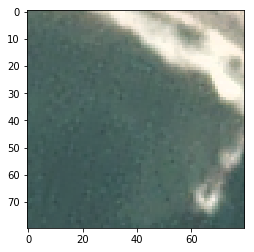

The coordinates for the image are: ((2400, 2480), (160, 240))
-----------------------
partial_ship  :  96.56085968017578
-----------------------
not_ship  :  3.4381337463855743
-----------------------
ship  :  0.0010051924618892372
-----------------------





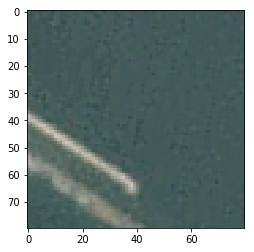

The coordinates for the image are: ((2400, 2480), (320, 400))
-----------------------
partial_ship  :  97.85849452018738
-----------------------
not_ship  :  2.125082351267338
-----------------------
ship  :  0.016429790412075818
-----------------------





The coordinates for the image are: ((2480, 2560), (320, 400))
-----------------------
partial_ship  :  98.71857762336731
-----------------------
not_ship  :  1.2806988321244717
-----------------------
ship  :  0.0007275257758010412
-----------------------





In [15]:
# Display the image and coordinates for ship and partial ship above 95%
print('The images with ship probabilities above 95% are: \n')
for i,each_result in enumerate(results_array2):
    predictions, percentage_probabilities = each_result["predictions"], each_result["percentage_probabilities"]
    prob_dict = {}
    for key,val in zip(each_result['predictions'],each_result['percentage_probabilities']):
        prob_dict[key]=val
    # Show the images which have a ship probability greater than 95:
    
    if float(prob_dict['ship']) > 95:
        plt.figure()
        plt.imshow(im_list[i])
        plt.show()
        print(f'The coordinates for the image are: {coords_list[i]}')
        print("-----------------------")
        for index in range(len(predictions)):
            print(predictions[index] , " : " , percentage_probabilities[index])
            print("-----------------------")
        print('\n\n')

print('\n\n\n')
print('The images with partial-ship probabilities above 95% are:')
for i,each_result in enumerate(results_array2):
    predictions, percentage_probabilities = each_result["predictions"], each_result["percentage_probabilities"]
    prob_dict = {}
    for key,val in zip(each_result['predictions'],each_result['percentage_probabilities']):
        prob_dict[key]=val
    # Show the images which have a partial ship probability greater than 95:
    if float(prob_dict['partial_ship']) > 95:
        plt.figure()
        plt.imshow(im_list[i])
        plt.show()
        print(f'The coordinates for the image are: {coords_list[i]}')
        print("-----------------------")
        for index in range(len(predictions)):
            print(predictions[index] , " : " , percentage_probabilities[index])
            print("-----------------------")
        print('\n\n')    

With a threshold of 95%, the ship identification is pretty good, finding the ship located in the squares. However, training of the partial ship category doesn't seemed to have improved the ability to find the general location of ships, and many false positives are being picked up. One problem seems to be the black edges of the image - many of the squares with black edges throw up a high reading for the partial-ship category.